In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GlueDataset,
    GlueDataTrainingArguments,
    Trainer,
    TrainingArguments,
    default_data_collator,
    glue_compute_metrics,
    glue_output_modes)
from influence_utils.utils_hans import HansDataset

import torch
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from influence_utils.influence import compute_s_test
from influence_utils import glue_utils

In [2]:
tokenizer = AutoTokenizer.from_pretrained("/export/home/Experiments/20200706/")
model = AutoModelForSequenceClassification.from_pretrained("/export/home/Experiments/20200706/")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model.eval()

train_dataset = GlueDataset(
    args=GlueDataTrainingArguments(
        task_name="mnli",
        max_seq_length=128,
        data_dir="/export/home/Data/Glue/MNLI/"),
    tokenizer=tokenizer)

# eval_dataset = HansDataset(
#     data_dir="/export/home/Data/HANS/",
#     tokenizer=tokenizer,
#     task="hans",
#     max_seq_length=128,
#     overwrite_cache=False,
#     evaluate=True,
# )
eval_dataset = GlueDataset(
    args=GlueDataTrainingArguments(
        task_name="mnli",
        max_seq_length=128,
        data_dir="/export/home/Data/Glue/MNLI/"),
    tokenizer=tokenizer,
    mode="dev")

In [3]:
glue_utils.freeze_BERT_parameters(model)
model.training, model.device

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

(False, device(type='cpu'))

In [4]:
def hans_data_collator(features):
    """
    Data collator that removes the "pairID" key if present.
    """
    batch = default_data_collator(features)
    _ = batch.pop("pairID", None)
    return batch


def get_dataloader(dataset, batch_size, data_collator) -> DataLoader:
    sampler = SequentialSampler(dataset)

    data_loader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return data_loader


def decode_one_example(inputs, logits=None):
    if inputs["input_ids"].shape[0] != 1:
        raise ValueError

    X = tokenizer.decode(inputs["input_ids"][0])
    Y = train_dataset.label_list[inputs["labels"].item()]
    if logits is not None:
        Y_hat = train_dataset.label_list[
            logits.argmax(dim=-1).item()]
        return X, Y, Y_hat
    else:
        return X, Y

output_mode = glue_output_modes["mnli"]
def build_compute_metrics_fn(task_name: str):
    def compute_metrics_fn(p):
        if output_mode == "classification":
            preds = np.argmax(p.predictions, axis=1)
        elif output_mode == "regression":
            preds = np.squeeze(p.predictions)
        return glue_compute_metrics(task_name, preds, p.label_ids)

    return compute_metrics_fn


trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
    data_collator=hans_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=build_compute_metrics_fn("mnli"),
)

train_batch_data_loader = get_dataloader(
    train_dataset,
    batch_size=160,
    data_collator=hans_data_collator)

train_instance_data_loader = get_dataloader(
    train_dataset,
    batch_size=1,
    data_collator=hans_data_collator)

eval_instance_data_loader = get_dataloader(
    eval_dataset,
    batch_size=1,
    data_collator=hans_data_collator)


def run_forward(model, inputs):
    # Implicitly used trainer and model
    has_labels = any(inputs.get(k) is not None for k in ["labels", "lm_labels", "masked_lm_labels"])

    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(trainer.args.device)
    if trainer.args.past_index >= 0:
        inputs["mems"] = past

    with torch.no_grad():
        outputs = model(**inputs)
        if has_labels:
            step_eval_loss, logits = outputs[:2]
            return step_eval_loss, logits
        else:
            logits = outputs[0]
            return logits
        
        
def visualize(inputs):
    X, Y = decode_one_example(inputs)
    premise, hypothesis = X.split("[CLS]")[1].split("[SEP]")[:2]
    print(f"\tP: {premise.strip()}\n\tH: {hypothesis.strip()}\n\tL: {Y}")

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
# trainer.evaluate()

In [6]:
for i, test_inputs in enumerate(eval_instance_data_loader):
    step_eval_loss, logits = run_forward(model, test_inputs)
    if i > 47 and (test_inputs["labels"] != logits.argmax(dim=1)).item():
        break

In [7]:
# i == 41
i

56

In [8]:
decode_one_example(test_inputs, logits)

('[CLS] But when the cushion is spent in a year or two, or when the next recession arrives, the disintermediating voters will find themselves playing the roles of budget analysts and tax wonks. [SEP] The cushion will likely be spent in under two years. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 'entailment',
 'contradiction')

In [9]:
visualize(test_inputs)

	P: But when the cushion is spent in a year or two, or when the next recession arrives, the disintermediating voters will find themselves playing the roles of budget analysts and tax wonks.
	H: The cushion will likely be spent in under two years.
	L: entailment


In [10]:
params_filter = None
weight_decay_ignores = None
weight_decay = 0.005
weight_decay_ignores = None
if params_filter is None:
    params_filter = [
        "bert.pooler.dense.weight",
        "bert.pooler.dense.bias"] + [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

# We actually included `bert.pooler.dense.*`
# but this should be fine? Because the gradients
# of these parameters are not included anyway.
if weight_decay_ignores is None:
    weight_decay_ignores = [
        "bias",
        "LayerNorm.weight"] + [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

s_test = compute_s_test(
    n_gpu=1,
    device=torch.device("cuda"),
    model=model,
    test_inputs=test_inputs,
    train_data_loaders=[train_batch_data_loader],
    params_filter=params_filter,
    weight_decay=weight_decay,
    weight_decay_ignores=weight_decay_ignores,
    scale=1000,
    num_samples=500)

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2004.46 | 0.42: : 502it [06:32,  1.28it/s]                        


In [11]:
# torch.save(s_test, "/export/home/Experiments/20200711/s_test.tmp.mnli-56")
s_test = torch.load("/export/home/Experiments/20200711/s_test.tmp.mnli-56")
from tqdm import tqdm
from influence_utils.influence import compute_gradients

In [1]:
# torch.save(influences, "/export/home/Experiments/20200705/influences.mnli.datapoint.1.pt")
# torch.save(influences, "/export/home/Experiments/20200711/influences.tmp.pt.full")
# torch.save(train_inputs_collections, "/export/home/Experiments/20200711/train_inputs_collections.tmp.pt.full")

In [14]:
np.argsort(influences)[-20:], np.array(influences)[np.argsort(influences)][-20:]

(array([216836, 326431, 218816,  36867, 380352, 223326, 237604, 268553,
        381986, 363628,  89700, 279334,  95249, 323822, 319395, 194456,
         90841, 168688, 262535,  85353]),
 array([0.14036317, 0.14306031, 0.14378235, 0.1461273 , 0.14649993,
        0.14799848, 0.14945602, 0.15174684, 0.15752681, 0.16009359,
        0.16218759, 0.16474044, 0.16808179, 0.16993859, 0.1724104 ,
        0.17394313, 0.18596108, 0.18791838, 0.19952127, 0.20359795]))

In [15]:
np.argsort(influences)[:20], np.array(influences)[np.argsort(influences)][:20]

(array([110640,  81545, 177068, 122861, 358305, 222796, 129406,  76226,
        296437, 164286, 307177, 161378, 215776, 183249,  55903, 217762,
        275820, 135803,  13489, 208537]),
 array([-0.27781412, -0.27341488, -0.26386681, -0.25751019, -0.24746615,
        -0.24185036, -0.23961194, -0.23698696, -0.23616295, -0.23593372,
        -0.23433471, -0.23358932, -0.22788872, -0.22712232, -0.2270966 ,
        -0.22686641, -0.22297204, -0.22289623, -0.22128047, -0.21829918]))

In [16]:
print("Top 3 Influential (harmful)")
visualize(train_inputs_collections[201907])
print()
visualize(train_inputs_collections[140485])
print()
visualize(train_inputs_collections[102963])

Top 3 Influential (harmful)
	P: Photos and documents tell the life story of the physician - revolutionary - statesman, who lived for a time in Macau, but never in this building.
	H: He never lived in this building.
	L: entailment

	P: He said he's never lost interest in having lawyers do what they can to help those in need.
	H: He's always been interesting in having lawyers help those who need it.
	L: entailment

	P: He did the saints Petronius and Proculus, and the angel on the right the first and last time he ever put wings on an angel.
	H: He had never put wings on any angels before.
	L: entailment


In [17]:
print("Top 3 Influential (helpful)")
visualize(train_inputs_collections[58075])
print()
visualize(train_inputs_collections[9102])
print()
visualize(train_inputs_collections[153048])

Top 3 Influential (helpful)
	P: i was surprised that last year was my first trip out there i'd never been to California and i went through out to Death Valley and
	H: I never went to California or Death Valley.
	L: contradiction

	P: I never noticed it when I took the tray up, but when I came to take it into the mistress's room I saw it at once, and I suppose I ought to have taken it down again, and asked Cook to make some fresh.
	H: I never noticed anything wrong with the tray.
	L: contradiction

	P: well that that that and that's an interesting point i've never i you know i've thought about it i've asked myself you know this question before i've never taken the time to do the research to answer my own question but i know that at least during the deliberations of the jury
	H: I have never asked myself questions.
	L: contradiction


In [222]:
from copy import deepcopy
import matplotlib.pyplot as plt

In [128]:
params_to_freeze = [
    "bert.embeddings.",
    "bert.encoder.layer.0.",
    "bert.encoder.layer.1.",
    "bert.encoder.layer.2.",
    "bert.encoder.layer.3.",
    "bert.encoder.layer.4.",
    "bert.encoder.layer.5.",
    "bert.encoder.layer.6.",
    "bert.encoder.layer.7.",
    "bert.encoder.layer.8.",
    "bert.encoder.layer.9.",
] + [
    "bert.pooler.dense.weight",
    "bert.pooler.dense.bias"]

Text(0.5, 1.0, 'Loss')

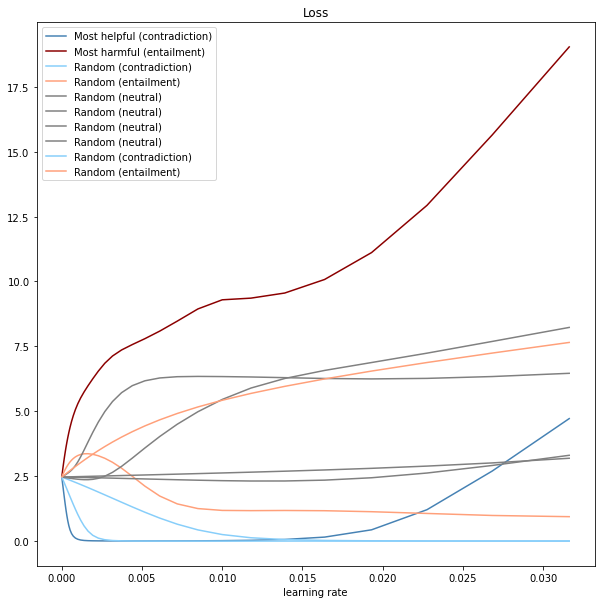

In [357]:
plt.rcParams["figure.figsize"] = (10, 10)
for j, c in zip([58075, 201907, 134448, 192584, 275967, 381952, 361464, 179400, 177993, 114332],
                ["steelblue", "darkred", "lightskyblue", "lightsalmon", "grey", "grey", "grey", "grey", "lightskyblue", "lightsalmon"]):

    learning_rates = np.logspace(-5, -1.5, 50)
    helpful_grad_z = compute_gradients(
        n_gpu=1,
        device=torch.device("cuda"),
        model=model,
        inputs=train_inputs_collections[j],
        params_filter=params_filter,
        weight_decay=weight_decay,
        weight_decay_ignores=weight_decay_ignores)

    step_eval_losses = []
    for lr in learning_rates:
        new_model = deepcopy(model)
        params_to_update = [p for name, p in new_model.named_parameters()
                            if not any(pfreeze in name for pfreeze in params_to_freeze)]
        with torch.no_grad():
            [p.sub_(lr * grad_z) for p, grad_z in zip(params_to_update, helpful_grad_z)]

        step_eval_loss, logits = run_forward(new_model, test_inputs)
        step_eval_losses.append(step_eval_loss)

    plt.plot(learning_rates, step_eval_losses, color=c)
plt.legend(["Most helpful (contradiction)",
            "Most harmful (entailment)",
            "Random (contradiction)",
            "Random (entailment)",
            "Random (neutral)",
            "Random (neutral)",
            "Random (neutral)",
            "Random (neutral)",
            "Random (contradiction)",
            "Random (entailment)",])
plt.xlabel("learning rate")
plt.title("Loss")
# plt.savefig("./20200709-fig2.pdf")

In [254]:
train_dataset.label_list

['contradiction', 'entailment', 'neutral']

In [342]:
np.random.randint(len(train_inputs_collections))

114332

In [363]:
step_eval_loss, logits = run_forward(model, test_inputs)
decode_one_example(test_inputs, logits)
logits.softmax(dim=-1), step_eval_loss

(tensor([[0.0848, 0.7960, 0.1192]], device='cuda:0'),
 tensor(2.4675, device='cuda:0'))

In [358]:
step_eval_loss, logits = run_forward(new_model, test_inputs)
decode_one_example(test_inputs, logits)

("[CLS] What's truly striking, though, is that Jobs has never really let this idea go. [SEP] Jobs never held onto an idea for long. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 'contradiction',
 'entailment')

In [172]:
with open("/export/home/Data/Glue/MNLI/train.tsv") as f:
    lines = f.readlines()

In [173]:
sorted_influences = np.argsort(influences)

(392703, 392683)

In [163]:
np.argsort(influences)[-20:]

array([ 25247, 148338, 217718, 369818, 162620,  79083, 380042, 103922,
       181647,   8238, 190388, 194137, 215463,  91299, 144572,  92812,
       158783, 102963, 140485, 201907])

In [209]:
import os
# for num in [1, 20, 100]:
for num in [1000, 3000]:
    random_dir_name = f"./MNLI_data/remove_{num}_random/"
    harmful_dir_name = f"./MNLI_data/remove_{num}_harmful/"
    helpful_dir_name = f"./MNLI_data/remove_{num}_helpful/"
    random_indices = np.random.choice(
        len(influences), size=num, replace=False)
    harmful_indices = sorted_influences[-num:]
    helpful_indices = sorted_influences[:num]

    
    for dir_name, indices in zip([
                                  # random_dir_name,
                                  harmful_dir_name,
                                  helpful_dir_name
                                 ],
                                 [
                                  # random_indices,
                                  harmful_indices,
                                  helpful_indices
                                 ]):
#         if not os.path.isdir(dir_name):
#             os.makedirs(dir_name)
#         else:
#             raise ValueError

#         with open(os.path.join(dir_name, "train.tsv"), "w") as f:
#             lines_to_write = [
#                 # "-1" because of the header line
#                 l for i, l in enumerate(lines)
#                 if i - 1 not in indices]

#             f.write("".join(lines_to_write))
#             print(f"Wrote {len(lines_to_write)} to {dir_name}")

        # Sanity checks
        print(dir_name)
        lines_to_remove = [
            # "-1" because of the header line
            l for i, l in enumerate(lines)
            if i - 1 in indices]
        print("\n\t".join(["     ".join(l.split("\t")[-4:-2]) for l in lines_to_remove][:1]))
        print("")

Wrote 391703 to ./MNLI_data/remove_1000_harmful/
Wrote 391703 to ./MNLI_data/remove_1000_helpful/
Wrote 389703 to ./MNLI_data/remove_3000_harmful/
Wrote 389703 to ./MNLI_data/remove_3000_helpful/
